# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.02193851, -0.1660529 , -0.01644062,  0.2757326 ]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.313567804407321 -3.0670273867693423


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    return actions, states, rewards

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(states, actions, rewards, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=actions_labels)
    R = tf.reduce_mean(rewards)
    loss = tf.reduce_mean(-log_prob*R)        
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, rewards=self.rewards) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
state = env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, reward])
    if done is True:
        break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([-0.10240309, -0.46245905,  0.219567  ,  1.16373206]), 1.0, 0)

In [ ]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state=env.reset()
        rewards_batch = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, reward])

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions, 
                                                                     model.states: states, 
                                                                     model.rewards: rewards})
            loss_batch.append(loss)
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(rewards.sum()),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))

        # At the end of each episode/epoch
        rewards_list.append((ep, rewards.sum()))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 Total reward: 477.0 Average loss: -0.908708811 Explore P: 0.997330605
Episode: 1 Total reward: 478.0 Average loss: -1.776481271 Explore P: 0.996245139
Episode: 2 Total reward: 479.0 Average loss: -4.795024395 Explore P: 0.993389171
Episode: 3 Total reward: 479.0 Average loss: -13.795257568 Explore P: 0.991228093
Episode: 4 Total reward: 481.0 Average loss: -49.265289307 Explore P: 0.986431836
Episode: 5 Total reward: 483.0 Average loss: -127.857116699 Explore P: 0.984188623
Episode: 6 Total reward: 485.0 Average loss: -378.043792725 Explore P: 0.977393115
Episode: 7 Total reward: 487.0 Average loss: -884.334106445 Explore P: 0.974398840
Episode: 8 Total reward: 491.0 Average loss: -1637.334350586 Explore P: 0.969205122
Episode: 9 Total reward: 491.0 Average loss: -2448.018310547 Explore P: 0.967958965
Episode: 10 Total reward: 492.0 Average loss: -3078.603027344 Explore P: 0.965471507
Episode: 11 Total reward: 493.0 Average loss: -3738.135009766 Explore P: 0.964611969
Episod

Episode: 95 Total reward: 500.0 Average loss: -20769848.000000000 Explore P: 0.757702329
Episode: 96 Total reward: 500.0 Average loss: -22237348.000000000 Explore P: 0.755835408
Episode: 97 Total reward: 500.0 Average loss: -22396208.000000000 Explore P: 0.753749990
Episode: 98 Total reward: 500.0 Average loss: -23437598.000000000 Explore P: 0.752338206
Episode: 99 Total reward: 500.0 Average loss: -23986968.000000000 Explore P: 0.749079094
Episode: 100 Total reward: 500.0 Average loss: -25361466.000000000 Explore P: 0.747307431
Episode: 101 Total reward: 500.0 Average loss: -26360894.000000000 Explore P: 0.746423192
Episode: 102 Total reward: 500.0 Average loss: -27085610.000000000 Explore P: 0.744657896
Episode: 103 Total reward: 500.0 Average loss: -27988096.000000000 Explore P: 0.740482258
Episode: 104 Total reward: 500.0 Average loss: -29427730.000000000 Explore P: 0.737493412
Episode: 105 Total reward: 500.0 Average loss: -30912680.000000000 Explore P: 0.736330353
Episode: 106 To

Episode: 186 Total reward: 500.0 Average loss: -387353888.000000000 Explore P: 0.522963629
Episode: 187 Total reward: 500.0 Average loss: -392750208.000000000 Explore P: 0.521989923
Episode: 188 Total reward: 500.0 Average loss: -398377312.000000000 Explore P: 0.519895062
Episode: 189 Total reward: 500.0 Average loss: -396469536.000000000 Explore P: 0.515680448
Episode: 190 Total reward: 500.0 Average loss: -402431008.000000000 Explore P: 0.513762508
Episode: 191 Total reward: 500.0 Average loss: -411976704.000000000 Explore P: 0.511651143
Episode: 192 Total reward: 500.0 Average loss: -420144128.000000000 Explore P: 0.510548723
Episode: 193 Total reward: 500.0 Average loss: -424172224.000000000 Explore P: 0.508999425
Episode: 194 Total reward: 500.0 Average loss: -434089312.000000000 Explore P: 0.507206257
Episode: 195 Total reward: 500.0 Average loss: -441820256.000000000 Explore P: 0.505221404
Episode: 196 Total reward: 500.0 Average loss: -439177312.000000000 Explore P: 0.502406671

Episode: 277 Total reward: 500.0 Average loss: -1964057728.000000000 Explore P: 0.356542319
Episode: 278 Total reward: 500.0 Average loss: -1991062144.000000000 Explore P: 0.355124404
Episode: 279 Total reward: 500.0 Average loss: -2038788864.000000000 Explore P: 0.353094165
Episode: 280 Total reward: 500.0 Average loss: -2076265728.000000000 Explore P: 0.351998018
Episode: 281 Total reward: 500.0 Average loss: -2116292224.000000000 Explore P: 0.349952174
Episode: 282 Total reward: 500.0 Average loss: -2153076480.000000000 Explore P: 0.348459670
Episode: 283 Total reward: 500.0 Average loss: -2185636608.000000000 Explore P: 0.346569593
Episode: 284 Total reward: 500.0 Average loss: -2219241984.000000000 Explore P: 0.345695649
Episode: 285 Total reward: 500.0 Average loss: -2286254592.000000000 Explore P: 0.344021360
Episode: 286 Total reward: 500.0 Average loss: -2321704704.000000000 Explore P: 0.342721214
Episode: 287 Total reward: 500.0 Average loss: -2356261632.000000000 Explore P: 

Episode: 367 Total reward: 500.0 Average loss: -7017916416.000000000 Explore P: 0.241737425
Episode: 368 Total reward: 500.0 Average loss: -7147741696.000000000 Explore P: 0.240535518
Episode: 369 Total reward: 500.0 Average loss: -7302167040.000000000 Explore P: 0.239684113
Episode: 370 Total reward: 500.0 Average loss: -7344574976.000000000 Explore P: 0.238904513
Episode: 371 Total reward: 500.0 Average loss: -7376989184.000000000 Explore P: 0.238264477
Episode: 372 Total reward: 500.0 Average loss: -7514110464.000000000 Explore P: 0.235993207
Episode: 373 Total reward: 500.0 Average loss: -7641582592.000000000 Explore P: 0.234978523
Episode: 374 Total reward: 500.0 Average loss: -7711137792.000000000 Explore P: 0.234484114
Episode: 375 Total reward: 500.0 Average loss: -7776573952.000000000 Explore P: 0.233364495
Episode: 376 Total reward: 500.0 Average loss: -7837445120.000000000 Explore P: 0.232918212
Episode: 377 Total reward: 500.0 Average loss: -7854044160.000000000 Explore P: 

Episode: 456 Total reward: 500.0 Average loss: -16733607936.000000000 Explore P: 0.171338549
Episode: 457 Total reward: 500.0 Average loss: -17024678912.000000000 Explore P: 0.169685290
Episode: 458 Total reward: 500.0 Average loss: -17343856640.000000000 Explore P: 0.169318436
Episode: 459 Total reward: 500.0 Average loss: -17477722112.000000000 Explore P: 0.168254571
Episode: 460 Total reward: 500.0 Average loss: -17780412416.000000000 Explore P: 0.167559780
Episode: 461 Total reward: 500.0 Average loss: -17951432704.000000000 Explore P: 0.167166373
Episode: 462 Total reward: 500.0 Average loss: -18054717440.000000000 Explore P: 0.166773948
Episode: 463 Total reward: 500.0 Average loss: -18134431744.000000000 Explore P: 0.166413782
Episode: 464 Total reward: 500.0 Average loss: -18453497856.000000000 Explore P: 0.164687189
Episode: 465 Total reward: 500.0 Average loss: -18779480064.000000000 Explore P: 0.164100493
Episode: 466 Total reward: 500.0 Average loss: -18885085184.000000000 

Episode: 546 Total reward: 500.0 Average loss: -35994038272.000000000 Explore P: 0.121386367
Episode: 547 Total reward: 500.0 Average loss: -36169433088.000000000 Explore P: 0.121097139
Episode: 548 Total reward: 500.0 Average loss: -36323512320.000000000 Explore P: 0.120775424
Episode: 549 Total reward: 500.0 Average loss: -36436561920.000000000 Explore P: 0.120178849
Episode: 550 Total reward: 500.0 Average loss: -36561276928.000000000 Explore P: 0.119892756
Episode: 551 Total reward: 500.0 Average loss: -36828340224.000000000 Explore P: 0.119596446
Episode: 552 Total reward: 500.0 Average loss: -37225209856.000000000 Explore P: 0.119180769
Episode: 553 Total reward: 500.0 Average loss: -37613019136.000000000 Explore P: 0.118647092
Episode: 554 Total reward: 500.0 Average loss: -38090723328.000000000 Explore P: 0.118289148
Episode: 555 Total reward: 500.0 Average loss: -38384402432.000000000 Explore P: 0.117867642
Episode: 556 Total reward: 500.0 Average loss: -38673928192.000000000 

Episode: 635 Total reward: 500.0 Average loss: -71275978752.000000000 Explore P: 0.084701856
Episode: 636 Total reward: 500.0 Average loss: -72677670912.000000000 Explore P: 0.084232714
Episode: 637 Total reward: 500.0 Average loss: -73285378048.000000000 Explore P: 0.084032556
Episode: 638 Total reward: 500.0 Average loss: -73820037120.000000000 Explore P: 0.083818173
Episode: 639 Total reward: 500.0 Average loss: -74399866880.000000000 Explore P: 0.083472041
Episode: 640 Total reward: 500.0 Average loss: -75137753088.000000000 Explore P: 0.083251955
Episode: 641 Total reward: 500.0 Average loss: -75567161344.000000000 Explore P: 0.083061748
Episode: 642 Total reward: 500.0 Average loss: -76364996608.000000000 Explore P: 0.082559357
Episode: 643 Total reward: 500.0 Average loss: -77300342784.000000000 Explore P: 0.082060421
Episode: 644 Total reward: 500.0 Average loss: -77690421248.000000000 Explore P: 0.081837379
Episode: 645 Total reward: 500.0 Average loss: -78231986176.000000000 

Episode: 723 Total reward: 500.0 Average loss: -128938885120.000000000 Explore P: 0.061213591
Episode: 724 Total reward: 500.0 Average loss: -129585799168.000000000 Explore P: 0.060993845
Episode: 725 Total reward: 500.0 Average loss: -130279653376.000000000 Explore P: 0.060856348
Episode: 726 Total reward: 500.0 Average loss: -130524160000.000000000 Explore P: 0.060673594
Episode: 727 Total reward: 500.0 Average loss: -131065757696.000000000 Explore P: 0.060531906
Episode: 728 Total reward: 500.0 Average loss: -131723886592.000000000 Explore P: 0.060305024
Episode: 729 Total reward: 500.0 Average loss: -132406878208.000000000 Explore P: 0.060044116
Episode: 730 Total reward: 500.0 Average loss: -132857643008.000000000 Explore P: 0.059739776
Episode: 731 Total reward: 500.0 Average loss: -133330714624.000000000 Explore P: 0.059595740
Episode: 732 Total reward: 500.0 Average loss: -133625167872.000000000 Explore P: 0.059471906
Episode: 733 Total reward: 500.0 Average loss: -133950660608

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

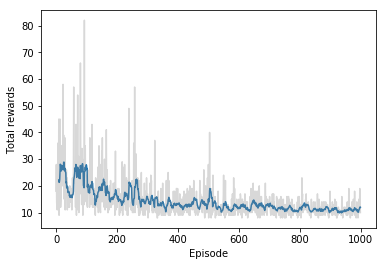

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

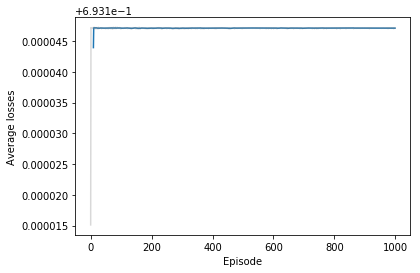

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        
        # Steps/batches
        for _ in range(111111111111111111111):
            env.render()
            
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            if done:
                break
                
    # Closing the env
    env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.